# **Section 3.1 Time series modeling using Recurrent neural networks**

In [ ]:
import torch
import torch.nn as nn
import yfinance as yf #If not installed: !pip install yfinance 
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 

**Preface**

This section is dedicated to practical implemetation of the Recurrent neural networks, we covered in the chapter two. Taking into account models architecture and data processing aspects that have to be performed before passing data into the model, a number of classes and custom functions were created.


# **Preprocessing section**

First of all, we need to load our data.  For that purpose, we used such a popular resource as Yahoo Finance, which provides relevant information on most tickers in the financial market. The series we are interested in are MSFT assets with a time period from 03/17/2018 to 01/25/2020. The reason we chose these observations instead of taking something more recent is because of the well-known pandemic that caused a market recession. Thus, modeling such volatile series would be inefficient. 

In [ ]:
data = yf.download('MSFT', start='2018-03-17', end='2020-01-25', progress=False)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-19,93.739998,93.900002,92.110001,92.889999,88.527275,33344100
2018-03-20,93.050003,93.769997,93.000000,93.129997,88.755989,23075200
2018-03-21,92.930000,94.050003,92.209999,92.480003,88.136536,24457100
2018-03-22,91.269997,91.750000,89.660004,89.790001,85.572868,38604700
2018-03-23,89.500000,90.459999,87.080002,87.180000,83.085442,44068900


The series we want analyse is contianed in the "Close" column. A well known thing is that scale may significantly reduce or, on the contrary, improve the convergence.That's why we need to compress our series to some specific range. But before we do that, let's take a logarithm to smooth them out a bit.

shape:  (467, 1)


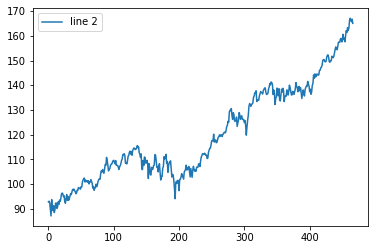

In [ ]:
price = data[['Close']].values
print("shape: ", price.shape)

plt.plot(range(price.shape[0]), price[:, 0], label = "line 2")
plt.legend()
plt.show()

In [ ]:
#Taking a log of initial series;
log_p = np.log(price)

There are many ways we can squeeze our data to some range, but the most common approaches are normalization and standardization. According to my belief, the second one is the only right option in the case of time series modeling.

When we are working with images where the pixels range between 0 and 255, we can apply normalization, being sure that the values will not go out of these boundaries. Whereas in the case of time series modeling, we cannot be sure of this.The reason we use the normalization below instead of other methods, including standardization, is because the result of such series were not as good as I thought.

Despite this, I still believe that standardization, which does not imply the presence of any bondaries, is the only right choice here. Зerhaps a little more time is needed to find the answer to these results.

In [ ]:
#Normalize the data with respect to the given range;
scaler = MinMaxScaler(feature_range=(-1,1))
stock_adj = scaler.fit_transform(log_p)

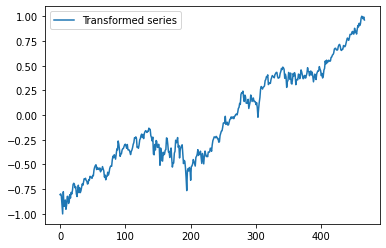

In [ ]:
plt.plot(range(len(stock_adj)), stock_adj, label = "Transformed series")
plt.legend()
plt.show()

As you can see from the picture above, our series is compressed in the range [-1;1]. This is actually what we want.

# **Data split function**

The next stage is related to data storage. In the chapter 2 we partially covered the idea behind batches and their structure. But we didn`t mention the way they are created. There are three main features that we need to consider: the length of the original series, the number of observations that we pass to the recurrent layer each time (input_size), and the number of such sequences on which we want our model to train (sequence_length).

The purpose of **data_split()** function, which is the custom one, is to create a set of batches given the parameters above. 

In [ ]:
def data_split(stock, input_size, seq_len): #data itself | input_size | number of sequences in batches (sequence_length);

  #step 1: creating an array of lagged values;
  data = stock

  for i in np.arange(-1, -(input_size + 1), -1):
    data = np.c_[data, np.roll(stock, i)]

  data = data[:-input_size, :]

  #step 2: spliting this array on batches;
  batches = []
  num_batches = len(data) - seq_len + 1

  for epoch in range(num_batches):
    batches.append(data[epoch:epoch + seq_len, :])

  batches = np.array(batches).astype(np.float32)

  #step 3: splitting batches on train and test sets;
  test_size = int(np.round(0.2 * batches.shape[0]))
  train_size = batches.shape[0] - test_size
  
  x_train = batches[:train_size, :, :-1] 
  y_train = batches[:train_size, -1, -1].reshape(-1, 1)

  x_test = batches[train_size:, :, :-1] 
  y_test = batches[train_size:, -1, -1].reshape(-1, 1)

  return x_train, y_train, x_test, y_test

In [ ]:
#This list of features is needed to set up the construction of our networks;
sequence_length = 10 #related only to the creation of batches;
input_size = 2
hidden_size = 20
num_layers = 2
output_size = 1
num_epochs = 200

As we can see from the code below, usage of this function may resemble the principle of train_test_split function from sklearn package. Note, that we also need to convert our numpy arrays into torch tensors.

In [ ]:
x_train, y_train, x_test, y_test = data_split(stock_adj, input_size, sequence_length) 

In [ ]:
x_train.shape

(365, 10, 2)

In [ ]:
y_train.shape

(365, 1)

In [ ]:
#converting numpy arrays into torch tensors;
xt_train = torch.from_numpy(x_train)
yt_train = torch.from_numpy(y_train)

xt_test = torch.from_numpy(x_test)
yt_test = torch.from_numpy(y_test)

After all preparations are made, we can conduct our analysis.

# **RNN model**

Neural networks are those models that need a huge number of data to be trained well. In our research we also want to compare our results with traditional model like Arima, Arch, Garch and so on. The length of initial sequece is also explained by that. Cause it will be not fair to give neural networks the adventage in the form of a larger amount of data. The way we can solve this problem is to increase the number of iterations (num_epochs).

At the same time, you need to remember about overfitting - the case when networks remember redundant information. It still wants to find and remember patterns within the data, but the goal has changed: instead of modeling a series, it will try to remember the series itself. This becomes apparent when comparing the accuracy of train and test sets.

In [ ]:
class RNN_m(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN_m, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    #Setting the initial values of hidden states;
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    #Computation of rnn layer;
    out, _ = self.rnn(x, h0)
    
    #Extracting the last hidden state for each batch and feeding them to the linear layer;
    #This is where we actually define the type of neural network (many-to-one);
    out = self.linear(out[:, -1, :])

    return(out)

In [ ]:
#Creating an instance of a class "RNN_m" - our RNN model;
model_0 = RNN_m(input_size, hidden_size, num_layers, output_size)
#setting the loss function;
criterion = nn.MSELoss(reduction='mean')
#optimization algorithm;
optimiser = torch.optim.Adam(model_0.parameters(), lr = 0.01)

In [ ]:
#array for loss collection;
rnn_loss = np.zeros(num_epochs)

start_time = time.time()

for t in range(num_epochs):
  #forward path;
  y_hat = model_0.forward(xt_train)
  #MSE computation;
  loss = criterion(y_hat, yt_train)

  #collecting the loss;
  with torch.no_grad():
    #print("Epoch: ", t, "MSE: ", loss.item())
    rnn_loss[t] = loss.item()
  
  #cleaning the gradients;
  optimiser.zero_grad()
  #backward path;
  loss.backward()
  #weights update;
  optimiser.step()

#time of training;
training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Training time: 1.1058268547058105


In [ ]:
#Estimates for training set: original | prediction ;
rnn_train = torch.cat((yt_train, y_hat.detach()), 1)

After training is finished, we want to save and visualize the obtained results. 

In [ ]:
sns.set_style("darkgrid") 

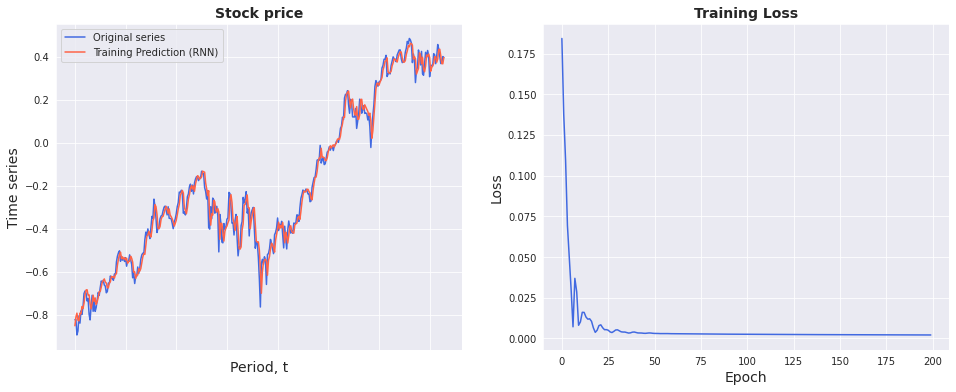

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(rnn_train.size(0)), y = rnn_train[:, 0], label="Original series", color='royalblue')
ax = sns.lineplot(x = range(rnn_train.size(0)), y = rnn_train[:, 1], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Period, t", size = 14)
ax.set_ylabel("Time series", size = 14)
ax.set_xticklabels('', size=10)

#
plt.subplot(1, 2, 2)
ax2 = sns.lineplot(data=rnn_loss, color='royalblue')
ax2.set_xlabel("Epoch", size = 14)
ax2.set_ylabel("Loss", size = 14)
ax2.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

According to the chart on the right, we can see that RNN did a good job. The predicted values are pretty close to the actual ones. Even, in areas with significant volatility, the accuracy is quite high.

At the same time, the chart of Loss provides some intuition behind the model training and can help us determine the optimal number of iterations. The main reason we plot this data is to make sure that the latest observations resemble a straight horizontal line. Otherwise, the presence of a slope may mean that the training was not carried out to the end.

Despite the training results, it's too early to talk about the model performance. In order to dispel any doubts, we need compute predictions for test set, provide comparison with respect to some criterion and visualize the results. This is what the code below actually does.



In [ ]:
#Test set prediction computation;
y_hat_test = model_0(xt_test).detach()
#Estimates for testing set: original | prediction ;
rnn_test = torch.cat((yt_test, y_hat_test), 1)

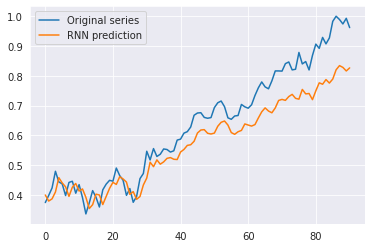

In [ ]:
plt.plot(range(len(yt_test)), yt_test, label = "Original series")
plt.plot(range(len(y_hat_test)), y_hat_test, label = "RNN prediction")
plt.legend()
plt.show()

According to the obtained results we can state a fact that the model performance is good enough. We can also notice that the predictions move away from the original data starting from the point where the series becomes growing. This concept is also known as extrapolation. We might be wondering why is this an issue? The answer is quite simple: we are asking the model to make predictions when our inputs are outside of the range of values it was trained on. 

If we compare the series in the area where the split was performed, we will notice that they are quite similar. This explains the accuracy for the first 20 observations in the test set. That is why in times series modeling we prefer to conduct the transformations like differencing. The fact that RNN is capable to predict the data so well is really amazing.

**RMSE calculation:**

In [ ]:
lstm_rmse_train = math.sqrt(criterion(rnn_train[:, 1], rnn_train[:, 0]))
print("RNN, train set: ", lstm_rmse_train, "RMSE")
lstm_rmse_test = math.sqrt(criterion(rnn_test[:, 1], rnn_test[:, 0]))
print("RNN, test set: ",lstm_rmse_test, "RMSE")

RNN, train set:  0.046486210786809125 RMSE
RNN, test set:  0.0818166394798395 RMSE


Using RMSE as the main criterion, we computed the estimates of both: training and test set. The corresponding values are 0.046 and 0.081 respectively. Thus, it can be argued that the results for the training set are twice as good as those for the test set. Taking into account the concept outlined above, we can note that the predictions are still quite well.

# **LSTM model**

In this section we are going to esimate the LSTM model using the same data and paramteres defined earlier. The criterion and optimization alorithm are not changed. The same is true for GRU model (next section). Thus, we will not dwell on the description of the learning processes of the model, but will present the results of the analysis and compare them with other models.

In [ ]:
class LSTM_m(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM_m, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    out, (hn, cn) = self.lstm(x, (h0, c0))
    
    out = self.linear(out[:, -1, :])

    return out

In [ ]:
model_1 = LSTM_m(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_1.parameters(), lr = 0.01)

In [ ]:
lstm_loss = np.zeros(num_epochs)
#
start_time = time.time()

for t in range(num_epochs):
  #forward path;
  y_hat = model_1.forward(xt_train)
  #MSE computation;
  loss = criterion(y_hat, yt_train)

  #collecting the loss;
  with torch.no_grad():
    #print("Epoch: ", t, "MSE: ", loss.item())
    lstm_loss[t] = loss.item()
  
  #cleaning the gradients;
  optimiser.zero_grad()
  #backward path;
  loss.backward()
  #weights update;
  optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Training time: 5.730298757553101


In [ ]:
#Estimates for training set: original | prediction ;
lstm_train = torch.cat((yt_train, y_hat.detach()), 1)

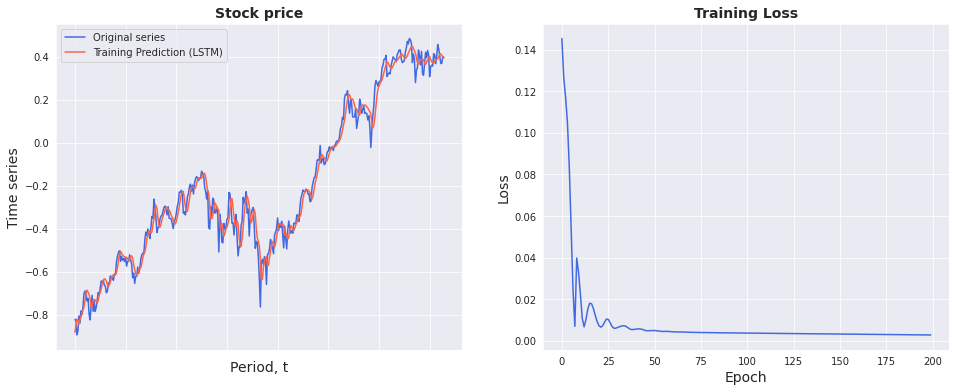

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(lstm_train.size(0)), y = lstm_train[:, 0], label="Original series", color='royalblue')
ax = sns.lineplot(x = range(lstm_train.size(0)), y = lstm_train[:, 1], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Period, t", size = 14)
ax.set_ylabel("Time series", size = 14)
ax.set_xticklabels('', size=10)

#
plt.subplot(1, 2, 2)
ax2 = sns.lineplot(data=lstm_loss, color='royalblue')
ax2.set_xlabel("Epoch", size = 14)
ax2.set_ylabel("Loss", size = 14)
ax2.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

As can be seen from the first plot, in the case of the LSTM model, the forecast line is smoother compared to the RNN model. The accuracy is clearly lower, especially at the end of the series. To find the answer to what caused this, we need to delve into the problematique of networks training.

Understanding of neural networks architectures, the processes of forward and back propagations is a big advantage. At the same time, the studies related to interrelation among the parameters we set, like: the number of inputs, hidden states and cell states (in the case of LSTM), the shape of the batches, the number of iterations the model is training, are no less important.
 
Scientists, who covered this area of analysis are trying to study this interrelation and the impact on model performance. In addition, there are a couple of frameworks that contain the coefficients obtained as a result of such studies for various models. Unfortunately, the papers published on well known resorces as **arxiv.org**, are represented without code. The only thing we can rely on is our understanding of how the analysis was done.

In [ ]:
#Test set prediction computation;
y_hat_test = model_1(xt_test).detach()
#Estimates for testing set: original | prediction ;
lstm_test = torch.cat((yt_test, y_hat_test), 1)

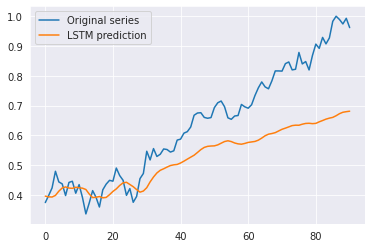

In [ ]:
plt.plot(range(len(yt_test)), yt_test, label = "Original series")
plt.plot(range(len(y_hat_test)), y_hat_test, label = "LSTM prediction")
plt.legend()
plt.show()

In compliance with the plot above, the model performance on the test set is much worse in comparison with RNN. The same conclusion can be drawn from the results of the RMSE estimates.

**RMSE calculation:**

In [ ]:
lstm_rmse_train = math.sqrt(criterion(lstm_train[:, 1], lstm_train[:, 0]))
print("LSTM, train set: ", lstm_rmse_train, "RMSE")
lstm_rmse_test = math.sqrt(criterion(lstm_test[:, 1], lstm_test[:, 0]))
print("LSTM, test set: ",lstm_rmse_test, "RMSE")

LSTM, train set:  0.05286020701636217 RMSE
LSTM, test set:  0.14771716486130998 RMSE


# **GRU model**

In [ ]:
class GRU_m(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GRU_m, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    out, hn = self.gru(x, h0)
    
    out = self.linear(out[:, -1, :])

    return out

In [ ]:
model_2 = GRU_m(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_2.parameters(), lr = 0.01)

In [ ]:
gru_loss = np.zeros(num_epochs)
#
start_time = time.time()

for t in range(num_epochs):
  #forward path;
  y_hat = model_2.forward(xt_train)
  #MSE computation;
  loss = criterion(y_hat, yt_train)

  #collecting the loss;
  with torch.no_grad():
    #print("Epoch: ", t, "MSE: ", loss.item())
    gru_loss[t] = loss.item()
  
  #cleaning the gradients;
  optimiser.zero_grad()
  #backward path;
  loss.backward()
  #weights update;
  optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Training time: 3.2937567234039307


In [ ]:
#Estimates for training set: original | prediction ;
gru_train = torch.cat((yt_train, y_hat.detach()), 1)

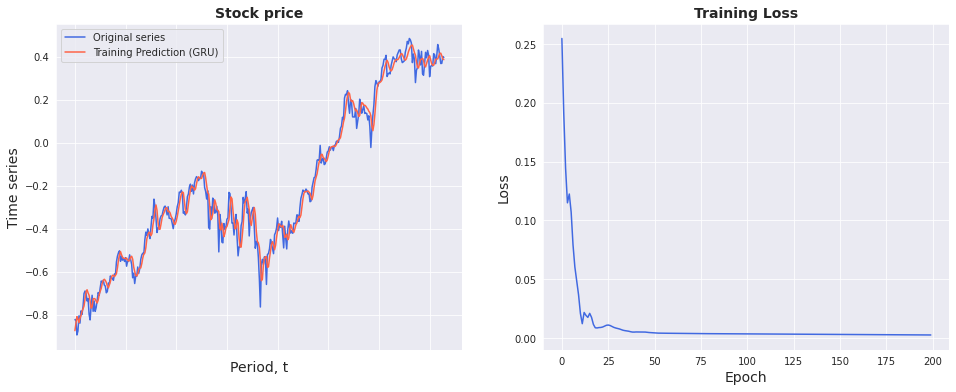

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(gru_train.size(0)), y = gru_train[:, 0], label="Original series", color='royalblue')
ax = sns.lineplot(x = range(gru_train.size(0)), y = gru_train[:, 1], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Period, t", size = 14)
ax.set_ylabel("Time series", size = 14)
ax.set_xticklabels('', size=10)

#
plt.subplot(1, 2, 2)
ax2 = sns.lineplot(data=gru_loss, color='royalblue')
ax2.set_xlabel("Epoch", size = 14)
ax2.set_ylabel("Loss", size = 14)
ax2.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

The results for the GRU model are similar to those for lstm. The predicted line is smoother compared to the RNN model, but close than in the case of lstm. The same is true for the test set and RMSE score.

Both models: GRU and LSTM are more powerful architectures of recurrent neural networks. In this analysis, I tried multiple data transformations in combination with various parameters related to the data structure and models themselves. But the results were not such significat to imrove the model performance. I will cover this aspect more deeper in the summary block.

In [ ]:
#Test set prediction computation;
y_hat_test = model_2(xt_test).detach()
#Estimates for testing set: original | prediction ;
gru_test = torch.cat((yt_test, y_hat_test), 1)

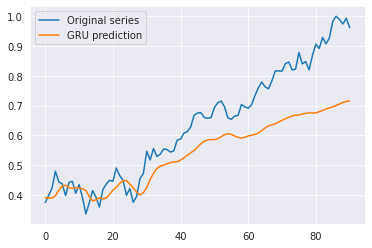

In [ ]:
plt.plot(range(len(yt_test)), yt_test, label = "Original series")
plt.plot(range(len(y_hat_test)), y_hat_test, label = "GRU prediction")
plt.legend()
plt.show()

**RMSE calculation:**

In [ ]:
gru_rmse_train = math.sqrt(criterion(gru_train[:, 1], gru_train[:, 0]))
print("LSTM, train set: ", lstm_rmse_train, "RMSE")
lstm_rmse_test = math.sqrt(criterion(gru_test[:, 1], gru_test[:, 0]))
print("LSTM, test set: ",lstm_rmse_test, "RMSE")

LSTM, train set:  0.05286020701636217 RMSE
LSTM, test set:  0.12780798881935806 RMSE


# **Predictions**

An accurate prediction is what we want our models to be able to do. From the contents of the previous sections, it becomes quite obvious that the network forecast will be inferior in accuracy compared to traditional models from Section 3.2. Despite this, it is still necessary to predict the series for one the period ahead (t+1).

The **batch_for_pred()** function was created for this. The idea is the same as the function we used to split our data on batches in the beginning. 

In [ ]:
def batch_for_pred(stock_f, input_size_f , seq_len_f):
  data = stock_f[-seq_len_f:]

  for i in range(1):
    data = np.c_[stock_f[-(seq_len_f+i+1):][:-(i+1)], data]

  batch_pred = torch.from_numpy(data.astype(np.float32)).unsqueeze(0)
  
  return batch_pred

But this time it returns the batch needed to make a forecast on one period ahead.

In [ ]:
#using batch_for_pred() we form the batch need to make a forecast. In our case it is t+1; 
X = batch_for_pred(stock_adj, 2, 10)
X

tensor([[[0.9064, 0.8922],
         [0.8922, 0.9289],
         [0.9289, 0.9072],
         [0.9072, 0.9270],
         [0.9270, 0.9828],
         [0.9828, 1.0000],
         [1.0000, 0.9889],
         [0.9889, 0.9741],
         [0.9741, 0.9930],
         [0.9930, 0.9619]]])

After feeding data into the in the models we trained, we got the predictions. 

In [ ]:
#forecast one prediod ahead, each model;
t1_rnn = model_0(X).detach()
t1_lstm = model_1(X).detach()
t1_gru = model_2(X).detach()

print(t1_rnn, t1_lstm, t1_gru)

tensor([[0.8136]]) tensor([[0.6812]]) tensor([[0.7169]])


To compare them with the value of the original series, we need to perform the reverse transformations to those that we did in the data processing section. The corresponding results are presented below.

In [ ]:
t1_rnn = np.exp(scaler.inverse_transform(t1_rnn))
t1_lstm = np.exp(scaler.inverse_transform(t1_lstm))
t1_gru = np.exp(scaler.inverse_transform(t1_gru))

print(t1_rnn, t1_lstm, t1_gru)

[[157.26672169]] [[150.63852871]] [[152.3969367]]


# **Summary**

Time series forecasting is an extremely complex thing. Nowadays have many machine learning algorithms that can detect patterns and capture those dependencies inside the series. They differ in the principle of operation,  complexity of architectures and also require different types of data processing. The Deep learning alogithms like RNN, LSTM anf GRU are widely used for this purpose. They are more powerful, in comparison with traditional models like Arima, Arch and Garch,  but also  more sophisticated.

In the scope of this reseach, we conducted the basic data processing operations and estimated three recurrent neural networks. In details covered the obained results and factors that make a direct influence on them. Also, a lot of work has been done that remains in the shadow of this study. In preparation for this analysis, I tested various data transformation methods on different series, including those used for traditional models. One of such experiments is represented below.

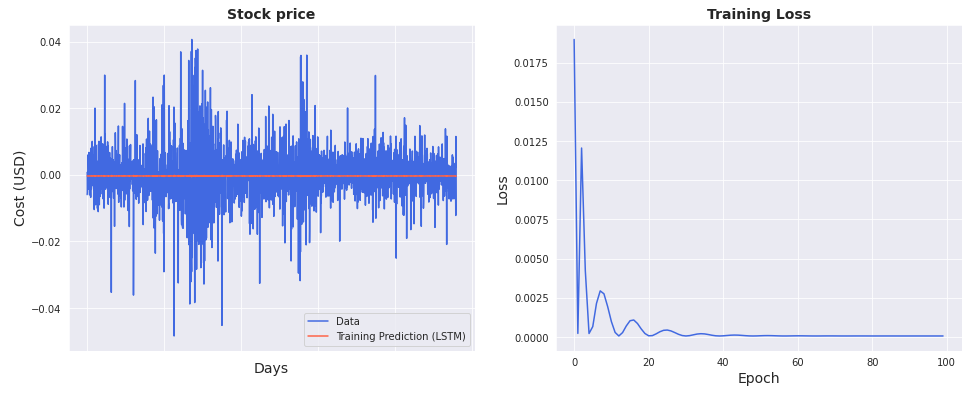

For testing I took a more volatile series of "AABA" ticker from 2006-01-03 to 2017-12-29. The transformation related to it includes:

1) taking a logarithm of initial series:

2) profit calculation using the formula: (x(t)-x(t-1))/x(t-1); 

Differentiation could also be use at the 2nd step. But here i wanted to avoid the problem of scale. Thus, the final series is logarithmic profit expressed as a percentage. At first glance, it seemed that the model did not train at all. The predictions resembled a straight horizontal line. But if we multiply this series on some value in order to increase their magnitude, we will gain the following:

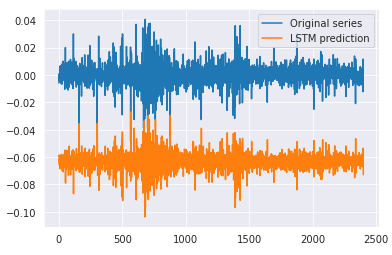

By increasing the value of the forecast, we see that it becomes meaningful. It is not a straight line indeed, but a series that's pretty close to the original one. I could not find an explanation for this phenomenon. But I will definitely do it once.

Returning to the analysis presented in this chapter, we should note that the models were trained on the original series, which was scaled in some way. In the case of traditional models, we want to make them stationary. These series have a constant mean, variance, and autocorrelation structure over time. If we try to evaluate them by the series we are using here, the results will be terrible. That's why I tend to think that these results are good enough.